In [1]:
# import libraries
import os, sys, glob
import numpy as np
import matplotlib.pyplot as plt
from icecube import icetray, dataclasses, dataio, recclasses
#sys.path.append('/home/ahinners/.local/lib/python3.11/site-packages')
#import simweights

In [2]:
# Load in IceCube CORSIKA Simulations
#bigfilelist = '/data/sim/IceCube/2020/filtered/dst/CORSIKA-in-ice/20904'
#corsika_fl = sorted(glob.glob(f'{bigfilelist}/*/*i3*'))
#0000000-0000999
#corsika_fl = corsika_fl[:50]

In [3]:
# file provided by Jaun-Carlos
d = np.load("/data/user/juancarlos/notebooks/dst_20904_v3.npz")
print(list(d.keys()))

['nchannel', 'llhZen', 'llhAz', 'zenith', 'azimuth', 'mc_energy', 'type', 'isgoodllh', 'ndir', 'ldir', 'rlogl', 'atmosphere', 'TriggID_1006', 'cogx', 'cogy', 'cogz', 'logMuE', 'energy', 'GaisserH3a', 'Hoerandel', 'GlobalFitGST', 'GlobalSplineFit5Comp', 'GaisserH4a', 'reco_energy']


In [4]:
#print(np.unique(d['type']))

In [5]:
#qual_cut = np.logical_and(d['zenith'] > 0.002, d['zenith'] < (np.pi - 0.002), d['nchannel'] >= 10)
#qual_cut += np.logical_and(qual_cut, d['isgoodllh'])
qual_cut = (d['zenith'] > 0.002) & (d['zenith'] < (np.pi - 0.002)) & (d['nchannel'] >= 10) & (d['isgoodllh'])

In [6]:
pcut = d['type'] == 2212
Hecut = d['type'] == 1.00002004e+09
Ncut = d['type'] == 1.000070140e+09
Alcut = d['type'] == 1.00013027e+09
Fecut =  d['type'] == 1.00026056e+09

In [7]:
BINS={
'4.125': np.logical_and(d['reco_energy'] > 4, d['reco_energy'] < 4.25),
'4.375': np.logical_and(d['reco_energy'] > 4.25, d['reco_energy'] < 4.5),
'4.625': np.logical_and(d['reco_energy'] > 4.5, d['reco_energy'] < 4.75),
'4.875': np.logical_and(d['reco_energy'] > 4.75, d['reco_energy'] < 5),
'5.125': np.logical_and(d['reco_energy'] > 5, d['reco_energy'] < 5.25),
'5.375': np.logical_and(d['reco_energy'] > 5.25, d['reco_energy'] < 5.5),
'5.75': np.logical_and(d['reco_energy'] > 5.5, d['reco_energy'] < 6),
'6.25': np.logical_and(d['reco_energy'] > 6, d['reco_energy'] < 6.5), 
'7.25': np.logical_and(d['reco_energy'] > 6.5, d['reco_energy'] < 8)
}


COLORS={
    'pRH': 'red',
    'pRG': 'red',
    'HeRH': 'orange',
    'HeRG': 'orange',
    'NRH': 'darkgreen',
    'NRG': 'darkgreen',
    'AlRH': 'blue',
    'AlRG': 'blue',
    'FeRH': 'purple',
    'FeRG': 'purple'
}

LABELS={
    'pRH': 'proton (H4a)',
    'pRG': 'proton (GSF)',
    'HeRH': 'Helium (H4a)',
    'HeRG': 'Helium (GSF)',
    'NRH': 'Nitrogen (H4a)',
    'NRG': 'Nitrogen (GSF)',
    'AlRH': 'Aluminum (H4a)',
    'AlRG': 'Aluminum (GSF)',
    'FeRH': 'Iron (H4a)',
    'FeRG': 'Iron (GSF)'
}

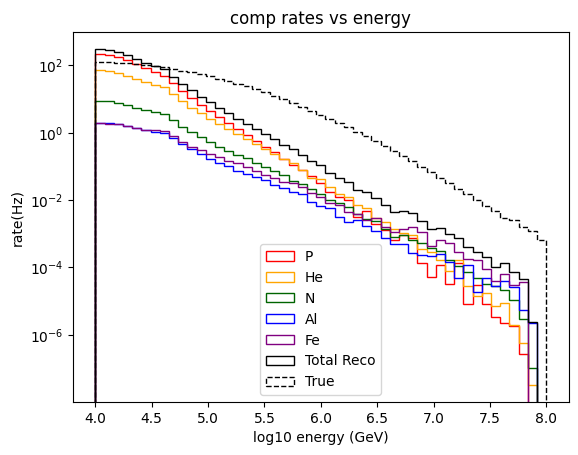

In [53]:
bins=np.linspace(4, 8, 50)

(pwtH, bins, patches1) = plt.hist(d['reco_energy'][pcut], bins = bins, log = True, weights=d['GaisserH4a'][pcut], color = 'red',histtype = 'step', label ='P')
(hwtH, bins, patches1) = plt.hist(d['reco_energy'][Hecut], bins = bins, log = True, weights=d['GaisserH4a'][Hecut],color = 'orange',histtype = 'step', label = 'He') 
(nwtH, bins, patches1) = plt.hist(d['reco_energy'][Ncut], bins = bins, log = True, weights=d['GaisserH4a'][Ncut], color='darkgreen',histtype = 'step', label = 'N')
(awtH, bins, patches1) = plt.hist(d['reco_energy'][Alcut], bins = bins, log = True, weights=d['GaisserH4a'][Alcut], color='blue',histtype = 'step', label = 'Al')
(iwtH, bins, patches1) = plt.hist(d['reco_energy'][Fecut], bins = bins, log=True, weights=d['GaisserH4a'][Fecut], color='purple', histtype='step',label='Fe')
(rwtH, bins, patches1) = plt.hist(d['reco_energy'], bins = bins, log = True, weights = d['GaisserH4a'], color = 'black', histtype = 'step', label = 'Total Reco')
(true, bins, patches1) = plt.hist(np.log10(d['energy']), bins = bins, log=True, weights = d['GaisserH4a'], color = 'black', histtype = 'step', label = 'True', linestyle = '--')
totH = pwtH + hwtH + nwtH + awtH + iwtH
plt.xlabel('log10 energy (GeV)')
plt.ylabel('rate(Hz)')
plt.title('comp rates vs energy')
plt.legend()
plt.show()

In [9]:
#pfracH4 = pwtH / totH
#fracH4 = hwtH / totH
#nfracH4 = nwtH / totH
#afracH4 = awtH / totH
#ifracH4 = iwtH / totH
#plt.plot(bins[:-1], pfracH4, label = 'P', color='red')
#plt.plot(bins[:-1], hfracH4, label = 'He', color='orange')
#plt.plot(bins[:-1], nfracH4, label = 'N', color='green')
#plt.plot(bins[:-1], afracH4, label = 'Al', color='blue')
#plt.plot(bins[:-1], ifracH4, label = 'Fe', color='purple')
#
#plt.xlabel('log10(Energy/GeV)')
#plt.ylabel('Fraction of Particles')
#lt.title('Particle Fraction vs. Energy')
#
#plt.legend()

In [10]:
# Mean Atomic Charge
#
#PZ = pwtH * np.log(1)
#HeZ = hwtH * np.log(2)
#NZ = nwtH * np.log(7)
#AlZ = awtH * np.log(13)
#FeZ = iwtH * np.log(26)
#totZ = PZ + HeZ + NZ + AlZ + FeZ
#meanZH = totZ / totH
#Mean_logZ_H4b = plt.plot(bins[:-1], meanZH)
#plt.xlabel('log10(Energy/GeV)')
#plt.ylabel('Mean ln(Z)')
#plt.title('Mean logZ vs. Energy')
#plt.show()

In [11]:
#PCOMP={
#'pCompH4': round(len(d['reco_energy'][pcut])/len(d['reco_energy']), 3),
#'hCompH4': round(len(d['reco_energy'][Hecut])/len(d['reco_energy']), 3),
#'nCompH4': round(len(d['reco_energy'][Ncut])/len(d['reco_energy']), 3),
#'aCompH4': round(len(d['reco_energy'][Alcut])/len(d['reco_energy']), 3),
#'fCompH4': round(len(d['reco_energy'][Fecut])/len(d['reco_energy']), 3)
#}

In [12]:
#for tier, tier_cut in zip(TIERS.keys(), TIERS.values()):
#    for comp, comp_cut in zip(CUTS.keys(), CUTS.values()):
#        if not comp=='true':
#            combined_cut = comp_cut * tier_cut * quality_cut
#                
#           PCOMP[tier][comp] = round(len(primary_energy[combined_cut])/len(primary_energy[tier_cut * quality_cut]), 3)
#            AVG_RIGIDITY[tier][comp] = np.log10(np.average(primary_energy[combined_cut]/Z[comp]))
#

In [13]:
def getEbins():
    return [4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 6, 6.5]
ebins = getEbins() + [8]
emids = (np.asarray(ebins)[1:] + np.asarray(ebins)[:-1])/2
print(emids)

[4.125 4.375 4.625 4.875 5.125 5.375 5.75  6.25  7.25 ]


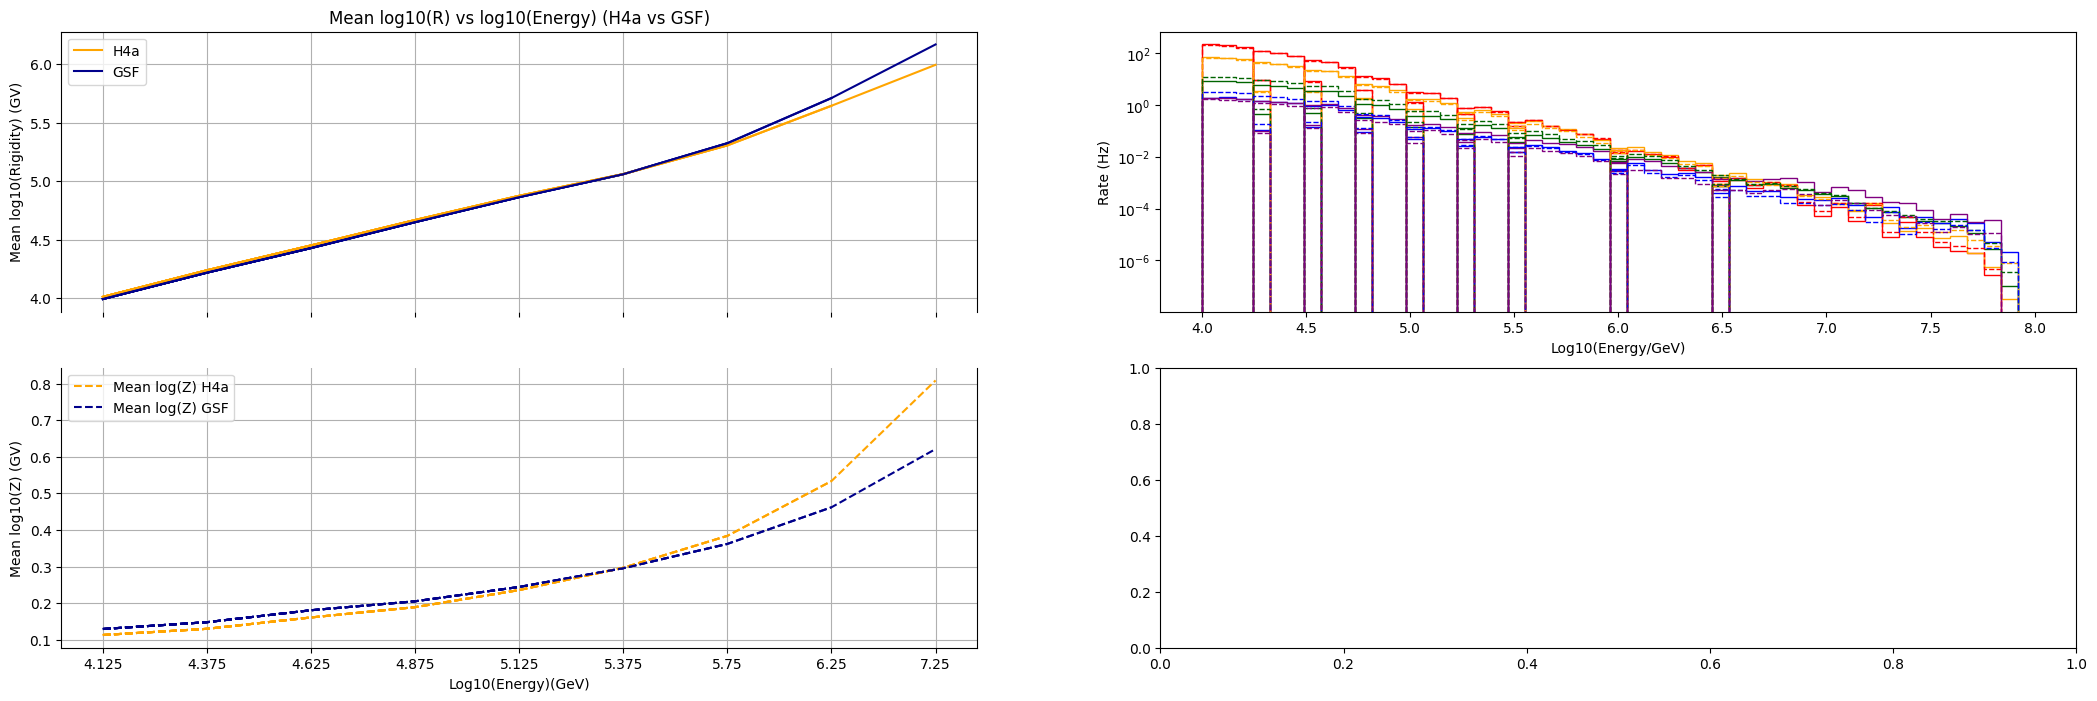

In [14]:
bins=np.linspace(4, 8, 50)
ncols=2
fig, axs = plt.subplots(figsize = (13 * ncols, 8), ncols=ncols, nrows=2)

rigidHArr = []
rigidGArr = []
meanZHArr=[]
meanZGArr=[]

for tier in BINS:
    totH = 0
    totG = 0

    # Plot the binned composition for GaisserH4a weight
    [pH, bins, patches1] = axs[0,1].hist(d['reco_energy'][np.logical_and(BINS[tier],pcut, qual_cut)], bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[tier],pcut)], color = 'red',histtype = 'step', label ='P', density=False)
    [HeH, bins, patches1] = axs[0,1].hist(d['reco_energy'][np.logical_and(BINS[tier],Hecut, qual_cut)], bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[tier],Hecut)], color = 'orange',histtype = 'step', label ='He', density=False)
    [NH, bins, patches1] = axs[0,1].hist(d['reco_energy'][np.logical_and(BINS[tier],Ncut, qual_cut)], bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[tier],Ncut)], color = 'darkgreen',histtype = 'step', label ='N', density=False)
    [AlH, bins, patches1] = axs[0,1].hist(d['reco_energy'][np.logical_and(BINS[tier],Alcut, qual_cut)], bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[tier],Alcut)], color = 'blue',histtype = 'step', label ='Al', density=False)
    [FeH, bins, patches1] = axs[0,1].hist(d['reco_energy'][np.logical_and(BINS[tier],Fecut, qual_cut)], bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[tier],Fecut)], color = 'purple',histtype = 'step', label ='Fe', density=False)
    totH = pH + HeH + NH + AlH + FeH
    
    # Plot the binned composition for GlobalSplineFit5Comp weight
    [pG, bins, patches1] = axs[0,1].hist(d['reco_energy'][np.logical_and(BINS[tier],pcut, qual_cut)], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier],pcut)], color = 'red',histtype = 'step', linestyle='--', label ='P', density=False)
    [HeG, bins, patches1] = axs[0,1].hist(d['reco_energy'][np.logical_and(BINS[tier],Hecut, qual_cut)], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier],Hecut)], color = 'orange',histtype = 'step', linestyle='--', label ='He', density=False)
    [NG, bins, patches1] = axs[0,1].hist(d['reco_energy'][np.logical_and(BINS[tier],Ncut, qual_cut)], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier],Ncut)], color = 'darkgreen',histtype = 'step', linestyle='--', label ='N', density=False)
    [AlG, bins, patches1] = axs[0,1].hist(d['reco_energy'][np.logical_and(BINS[tier],Alcut, qual_cut)], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier],Alcut)], color = 'blue',histtype = 'step', linestyle='--', label ='Al', density=False)
    [FeG, bins, patches1] = axs[0,1].hist(d['reco_energy'][np.logical_and(BINS[tier],Fecut, qual_cut)], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier],Fecut)], color = 'purple',histtype = 'step', linestyle='--', label ='Fe', density=False)
    totG = pG + HeG + NG + AlG + FeG
    
    # Calculate the discrete binned fractional composition for the GaisserH4a weight
    pfracH = np.nanmean(pH) / np.nanmean(totH)
    HefracH = np.nanmean(HeH) / np.nanmean(totH)
    NfracH = np.nanmean(NH) / np.nanmean(totH)
    AlfracH = np.nanmean(AlH) / np.nanmean(totH)
    FefracH = np.nanmean(FeH) / np.nanmean(totH)

    # Calculate the discrete binned fractional composition for the GlobalSplineFit5Comp weight
    pfracG = np.nanmean(pG) / np.nanmean(totG)
    HefracG = np.nanmean(HeG) / np.nanmean(totG)
    NfracG = np.nanmean(NG) / np.nanmean(totG)
    AlfracG = np.nanmean(AlG) / np.nanmean(totG)
    FefracG = np.nanmean(FeG) / np.nanmean(totG)
    
    # Calculate the mean base 10 log charge and atomic mass for GaisserH4a weight
    meanAH = ((pfracH * np.log10(1)) + (HefracH*np.log10(4)) + (NfracH*np.log10(14)) + (AlfracH*np.log10(27)) + (FefracH*np.log10(56)))
    meanZH = ((pfracH*np.log10(1)) + (HefracH*np.log10(2)) + (NfracH*np.log10(7)) + (AlfracH*np.log10(13)) + (FefracH*np.log10(26)))

    # Calculate the mean base 10 log charge and atomic mass for GlobalSplineFit5Comp weight
    meanAG= ((pfracG * np.log10(1)) + (HefracG*np.log10(4)) + (NfracG*np.log10(14)) + (AlfracG*np.log10(27)) + (FefracG*np.log10(56)))
    meanZG = ((pfracG*np.log10(1)) + (HefracG*np.log10(2)) + (NfracG*np.log10(7)) + (AlfracG*np.log10(13)) + (FefracG*np.log10(26)))

    # Calculate the discrete weighted rigidities (for rgidity line graph)
    rigidH = np.average(d['reco_energy'][np.logical_and(BINS[tier], qual_cut)], weights=d['GaisserH4a'][np.logical_and(BINS[tier], qual_cut)]) - (meanZH / 1)
    rigidG = np.average(d['reco_energy'][np.logical_and(BINS[tier], qual_cut)], weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier], qual_cut)]) - (meanZG / 1)
    
    # Print values
    #print('**Energy bin: ' + tier + '**')
    #print('--------------------')
    #print('Proton (H4a): ' + str(round(pfracH, 3)))
    #print('Proton (GSF): ' + str(round(pfracG, 3)))
    #print('|--------------------|')
    #print('Helium (H4a): ' + str(round(HefracH, 3)))
    #print('Helium (GSF): ' + str(round(HefracG, 3)))
    #print('|--------------------|')
    #print('Nitrogen (H4a): ' + str(round(NfracH, 3)))
    #print('Nitrogen (GSF): ' + str(round(NfracG, 3)))
    #print('|--------------------|')
    #print('Aluminum (H4a): ' + str(round(AlfracH, 3)))
    #print('Aluminum (GSF): ' + str(round(AlfracG, 3)))
    #print('|--------------------|')
    #print('Iron (H4a): ' + str(round(FefracH, 3)))
    #print('Iron (GSF): ' + str(round(FefracG, 3)))
    #print('--------------------')
    #print('Mean Log10(Z) (H4a): ' + str(round(meanZH, 3)))
    #print('Mean Log10(Z) (GSF): ' + str(round(meanZG, 3)))
    #print('|--------------------|')
    #print('Mean Log10(A) (H4a): ' + str(round(meanAH, 3)))
    #print('Mean Log10(A) (GSF): ' + str(round(meanAG, 3)))
    #print('|--------------------|')
    #print('Mean log10(R) (H4a): ' + str(round(rigidH, 3)))
    #print('Mean log10(R) (GSF): ' + str(round(rigidG, 3)))
    #print()

    rigidHArr.append(rigidH)
    rigidGArr.append(rigidG)
    meanZHArr.append(meanZH)
    meanZGArr.append(meanZG)

    # Plot discrete rigidity (for rigidity line chart)
    axs[0,0].plot(rigidHArr, label='H4a' if tier == '4.125' else '', color='orange')
    axs[0,0].plot(rigidGArr, label='GSF' if tier == '4.125' else '', color='darkblue')
    axs[1,0].plot(meanZHArr, label='Mean log(Z) H4a' if tier == '4.125' else '', color='orange', linestyle='--')
    axs[1,0].plot(meanZGArr, label='Mean log(Z) GSF' if tier == '4.125' else '', color='darkblue', linestyle='--')
    
# Show plots
axs[0,1].set_xlabel('Log10(Energy/GeV)')
axs[0,1].set_ylabel('Rate (Hz)')
#axs[0,1].set_title('Binned Composition Rates vs. Energy')
axs[0,0].set_title('Mean log10(R) vs log10(Energy) (H4a vs GSF)')
axs[1,0].set_xlabel('Log10(Energy)(GeV)')
axs[0,0].set_ylabel('Mean log10(Rigidity) (GV)')
axs[1,0].set_ylabel('Mean log10(Z) (GV)')
axs[1,0].set_xticks(np.arange(0,9,1))
axs[1,0].set_xticklabels(['4.125','4.375','4.625','4.875','5.125','5.375','5.75','6.25','7.25'])
axs[0,0].set_xticklabels('')
axs[0,0].spines['bottom'].set_visible(False)
axs[1,0].spines['top'].set_visible(False)
axs[0,0].grid()
axs[1,0].grid()
axs[0,0].legend()
axs[1,0].legend()
plt.show()

In [37]:
#define a function to go from PDG code to Z
def _get_charge(ptype):
    if ptype<1000020040:
        return 1
    else:
        remainder = int(ptype)%1000000000
        remainder -= remainder%1000
        
        return remainder/10000
    
#turn it into a vectorized function (for speed)
get_charge = np.vectorize(_get_charge)

#example of usage
zarray = get_charge(d['type'])

In [50]:
def weighted_quantiles(values, weights, quantiles=0.5):
    i = np.argsort(values)
    c = np.cumsum(weights[i])
    return values[i[np.searchsorted(c, np.array(quantiles) * c[-1])]]

In [48]:
lza = np.log10(zarray)

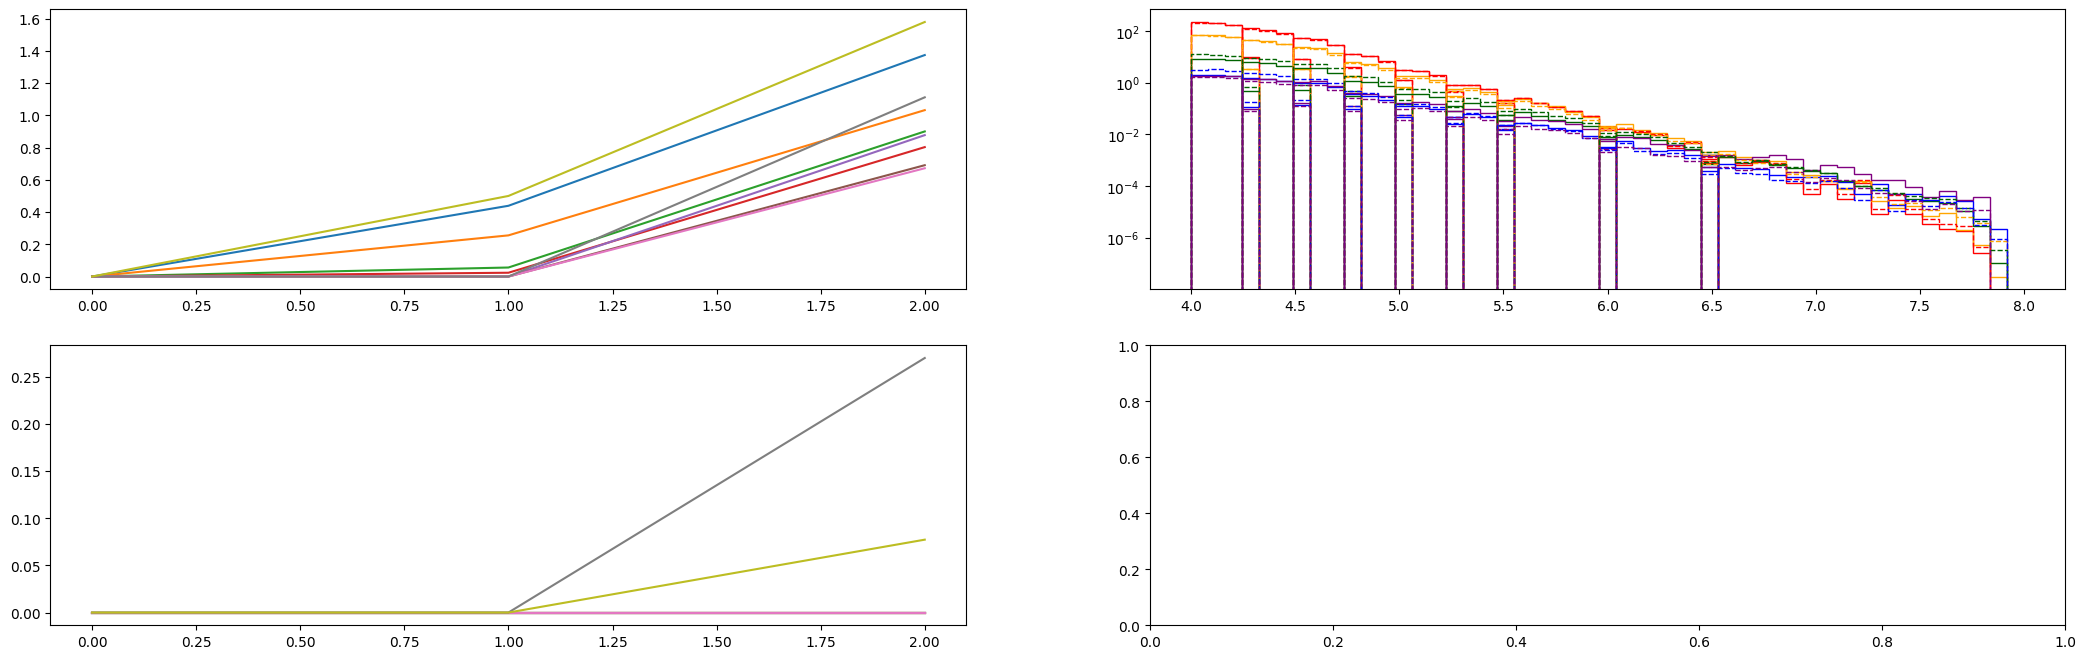

In [100]:
bins=np.linspace(4, 8, 50)
ncols=2
fig, axs = plt.subplots(figsize = (13 * ncols, 8), ncols=ncols, nrows=2)
for tier in BINS:
    totH=0
    totG=0
    # Plot the binned composition for GaisserH4a weight
    [pH, bins, patches1] = axs[0,1].hist(d['reco_energy'][np.logical_and(BINS[tier],pcut, qual_cut)], bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[tier],pcut)], color = 'red',histtype = 'step', label ='P', density=False)
    [HeH, bins, patches1] = axs[0,1].hist(d['reco_energy'][np.logical_and(BINS[tier],Hecut, qual_cut)], bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[tier],Hecut)], color = 'orange',histtype = 'step', label ='He', density=False)
    [NH, bins, patches1] = axs[0,1].hist(d['reco_energy'][np.logical_and(BINS[tier],Ncut, qual_cut)], bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[tier],Ncut)], color = 'darkgreen',histtype = 'step', label ='N', density=False)
    [AlH, bins, patches1] = axs[0,1].hist(d['reco_energy'][np.logical_and(BINS[tier],Alcut, qual_cut)], bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[tier],Alcut)], color = 'blue',histtype = 'step', label ='Al', density=False)
    [FeH, bins, patches1] = axs[0,1].hist(d['reco_energy'][np.logical_and(BINS[tier],Fecut, qual_cut)], bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[tier],Fecut)], color = 'purple',histtype = 'step', label ='Fe', density=False)
    #[totH, bins, patches1] = axs[0,1].hist(d['reco_energy'][BINS[tier]], bins = bins, log = True, weights=d['GaisserH4a'][(BINS[tier])], color='black',histtype='step', label='total',density=False)
    totH = pH + HeH + NH + AlH + FeH
    
    # Plot the binned composition for GlobalSplineFit5Comp weight
    [pG, bins, patches1] = axs[0,1].hist(d['reco_energy'][np.logical_and(BINS[tier],pcut, qual_cut)], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier],pcut)], color = 'red',histtype = 'step', linestyle='--', label ='P', density=False)
    [HeG, bins, patches1] = axs[0,1].hist(d['reco_energy'][np.logical_and(BINS[tier],Hecut, qual_cut)], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier],Hecut)], color = 'orange',histtype = 'step', linestyle='--', label ='He', density=False)
    [NG, bins, patches1] = axs[0,1].hist(d['reco_energy'][np.logical_and(BINS[tier],Ncut, qual_cut)], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier],Ncut)], color = 'darkgreen',histtype = 'step', linestyle='--', label ='N', density=False)
    [AlG, bins, patches1] = axs[0,1].hist(d['reco_energy'][np.logical_and(BINS[tier],Alcut, qual_cut)], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier],Alcut)], color = 'blue',histtype = 'step', linestyle='--', label ='Al', density=False)
    [FeG, bins, patches1] = axs[0,1].hist(d['reco_energy'][np.logical_and(BINS[tier],Fecut, qual_cut)], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier],Fecut)], color = 'purple',histtype = 'step', linestyle='--', label ='Fe', density=False)
    #[totG, bins, patches1] = axs[0,1].hist(d['reco_energy'][BINS[tier]], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][(BINS[tier])], color='black',histtype='step', label='total',linestyle='--', density=False)
    totG = pG + HeG + NG + AlG + FeG
        
    # Calculate the discrete binned fractional composition for the GaisserH4a weight
    pfracH = np.nanmean(pH) / np.nanmean(totH)
    HefracH = np.nanmean(HeH) / np.nanmean(totH)
    NfracH = np.nanmean(NH) / np.nanmean(totH)
    AlfracH = np.nanmean(AlH) / np.nanmean(totH)
    FefracH = np.nanmean(FeH) / np.nanmean(totH)

    # Calculate the discrete binned fractional composition for the GlobalSplineFit5Comp weight
    pfracG = np.nanmean(pG) / np.nanmean(totG)
    HefracG = np.nanmean(HeG) / np.nanmean(totG)
    NfracG = np.nanmean(NG) / np.nanmean(totG)
    AlfracG = np.nanmean(AlG) / np.nanmean(totG)
    FefracG = np.nanmean(FeG) / np.nanmean(totG)
    
    # Calculate the mean base 10 log charge and atomic mass for GaisserH4a weight
    meanZH = ((pfracH*np.log10(1)) + (HefracH*np.log10(2)) + (NfracH*np.log10(7)) + (AlfracH*np.log10(13)) + (FefracH*np.log10(26)))

    # Calculate the mean base 10 log charge and atomic mass for GlobalSplineFit5Comp weight
    meanZG = ((pfracG*np.log10(1)) + (HefracG*np.log10(2)) + (NfracG*np.log10(7)) + (AlfracG*np.log10(13)) + (FefracG*np.log10(26)))

    # Calculate the discrete weighted rigidities (for rgidity line graph)
    rigidH = np.average(d['reco_energy'][np.logical_and(BINS[tier], qual_cut)], weights=d['GaisserH4a'][np.logical_and(BINS[tier], qual_cut)]) - (meanZH / 1)
    rigidG = np.average(d['reco_energy'][np.logical_and(BINS[tier], qual_cut)], weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier], qual_cut)]) - (meanZG / 1)
    
    # Weighted quantiles the fractional composition
    pfhw = weighted_quantiles(pfracH, d['GaisserH4a'], [.1,.5,.9])
    hfhw = weighted_quantiles(HefracH, d['GaisserH4a'], [.1,.5,.9])
    nfhw = weighted_quantiles(NfracH, d['GaisserH4a'], [.1,.5,.9])
    afhw = weighted_quantiles(AlfracH, d['GaisserH4a'], [.1,.5,.9])
    ifhw = weighted_quantiles(FefracH, d['GaisserH4a'], [.1,.5,.9])
    
    pfgw = weighted_quantiles(pfracH, d['GlobalSplineFit5Comp'], [.1,.5,.9])
    hfgw = weighted_quantiles(HefracH, d['GlobalSplineFit5Comp'], [.1,.5,.9])
    nfgw = weighted_quantiles(NfracH, d['GlobalSplineFit5Comp'], [.1,.5,.9])
    afgw = weighted_quantiles(AlfracH, d['GlobalSplineFit5Comp'], [.1,.5,.9])
    ifgw = weighted_quantiles(FefracH, d['GlobalSplineFit5Comp'], [.1,.5,.9])


    #bins= (bins[:1]-bins[1:])/2
    sumZH = ((pfhw * np.log10(1)) + (hfhw*np.log10(2)) + (nfhw*np.log10(7)) + (afhw*np.log10(13)) + (ifhw*np.log10(26)))/1
    medZH = np.median(sumZH)
    axs[0,0].plot(sumZH)
    axs[1,0].plot(pfgw)
    #print('median log10(Z): ' + str(round(medZH, 3)))

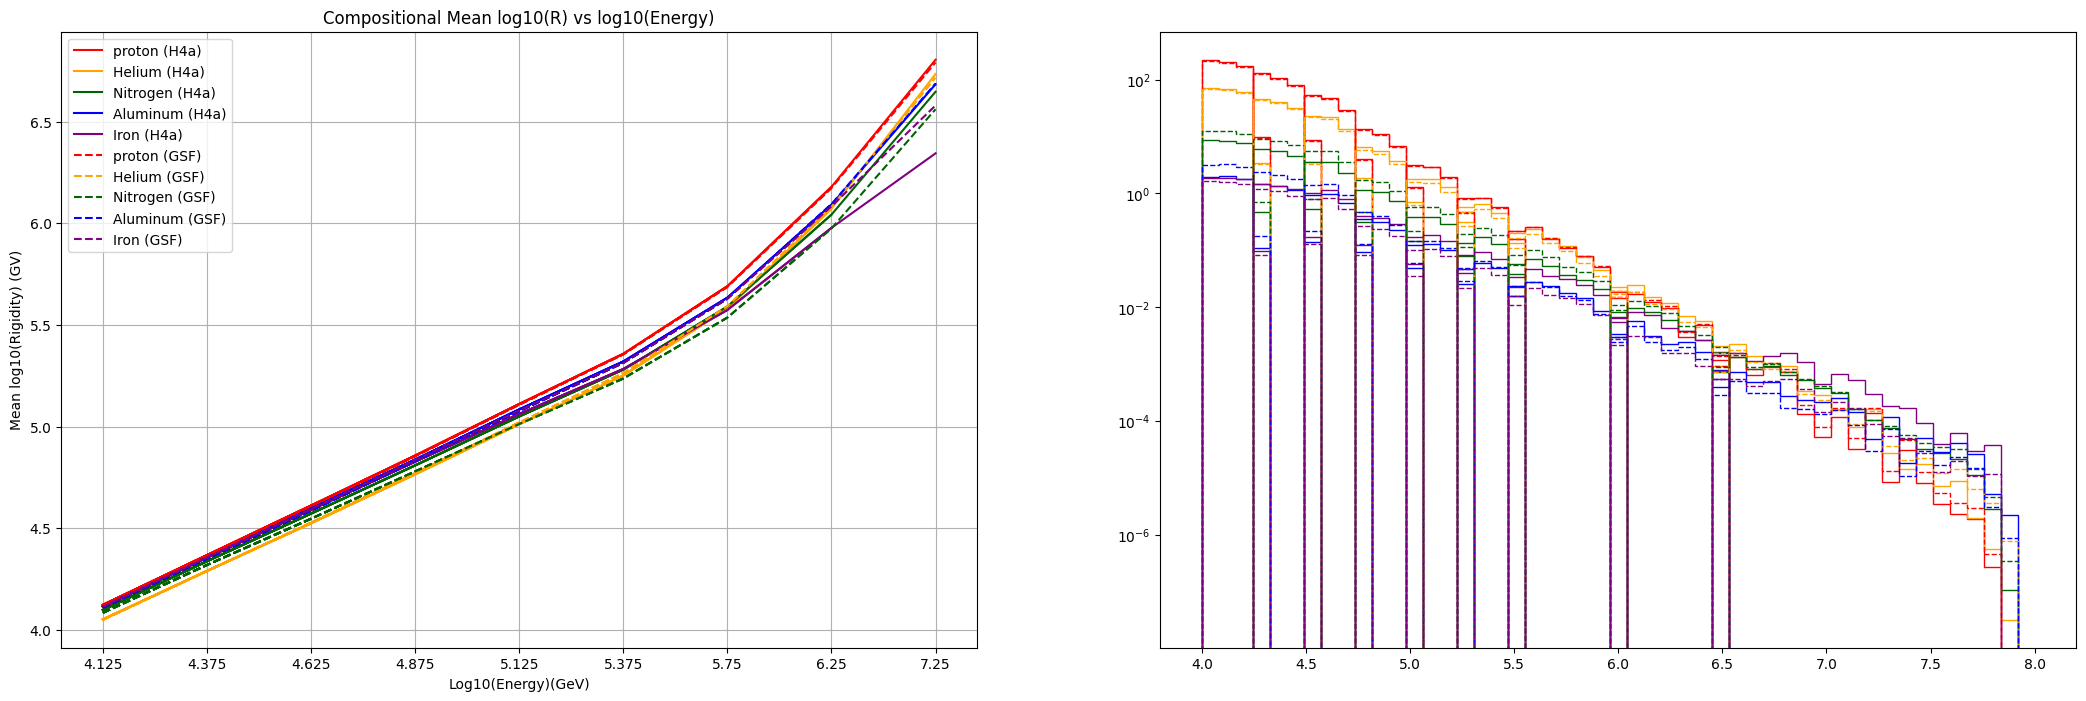

In [63]:
bins=np.linspace(4, 8, 50)
ncols=2
fig, axs = plt.subplots(figsize = (13 * ncols, 8), ncols=ncols)
RigiDH = {
    'pRH': [],
    'HeRH': [],
    'NRH': [],
    'AlRH': [],
    'FeRH': []
}

RigiDG = {
    'pRG':  [],
    'HeRG': [],
    'NRG': [],
    'AlRG': [],
    'FeRG': []
}
for tier in BINS:
    totH = 0
    totG = 0

    # Plot the binned composition for GaisserH4a weight
    [pH, bins, patches1] = axs[1].hist(d['reco_energy'][np.logical_and(BINS[tier],pcut, qual_cut)], bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[tier],pcut)], color = 'red',histtype = 'step', label ='P', density=False)
    [HeH, bins, patches1] = axs[1].hist(d['reco_energy'][np.logical_and(BINS[tier],Hecut, qual_cut)], bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[tier],Hecut)], color = 'orange',histtype = 'step', label ='He', density=False)
    [NH, bins, patches1] = axs[1].hist(d['reco_energy'][np.logical_and(BINS[tier],Ncut, qual_cut)], bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[tier],Ncut)], color = 'darkgreen',histtype = 'step', label ='N', density=False)
    [AlH, bins, patches1] = axs[1].hist(d['reco_energy'][np.logical_and(BINS[tier],Alcut, qual_cut)], bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[tier],Alcut)], color = 'blue',histtype = 'step', label ='Al', density=False)
    [FeH, bins, patches1] = axs[1].hist(d['reco_energy'][np.logical_and(BINS[tier],Fecut, qual_cut)], bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[tier],Fecut)], color = 'purple',histtype = 'step', label ='Fe', density=False)
    totH = pH + HeH + NH + AlH + FeH
    
    # Plot the binned composition for GlobalSplineFit5Comp weight
    [pG, bins, patches1] = axs[1].hist(d['reco_energy'][np.logical_and(BINS[tier],pcut, qual_cut)], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier],pcut)], color = 'red',histtype = 'step', linestyle='--', label ='P', density=False)
    [HeG, bins, patches1] = axs[1].hist(d['reco_energy'][np.logical_and(BINS[tier],Hecut, qual_cut)], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier],Hecut)], color = 'orange',histtype = 'step', linestyle='--', label ='He', density=False)
    [NG, bins, patches1] = axs[1].hist(d['reco_energy'][np.logical_and(BINS[tier],Ncut, qual_cut)], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier],Ncut)], color = 'darkgreen',histtype = 'step', linestyle='--', label ='N', density=False)
    [AlG, bins, patches1] = axs[1].hist(d['reco_energy'][np.logical_and(BINS[tier],Alcut, qual_cut)], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier],Alcut)], color = 'blue',histtype = 'step', linestyle='--', label ='Al', density=False)
    [FeG, bins, patches1] = axs[1].hist(d['reco_energy'][np.logical_and(BINS[tier],Fecut, qual_cut)], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier],Fecut)], color = 'purple',histtype = 'step', linestyle='--', label ='Fe', density=False)
    totG = pG + HeG + NG + AlG + FeG

    # Calculate the discrete binned fractional composition for the GaisserH4a weight    
    pfracH = np.nanmean(pH) / np.nanmean(totH)
    HefracH = np.nanmean(HeH) / np.nanmean(totH)
    NfracH = np.nanmean(NH) / np.nanmean(totH)
    AlfracH = np.nanmean(AlH) / np.nanmean(totH)
    FefracH = np.nanmean(FeH) / np.nanmean(totH)

    # Calculate the discrete binned fractional composition for the GlobalSplineFit5Comp weight
    pfracG = np.nanmean(pG) / np.nanmean(totG)
    HefracG = np.nanmean(HeG) / np.nanmean(totG)
    NfracG = np.nanmean(NG) / np.nanmean(totG)
    AlfracG = np.nanmean(AlG) / np.nanmean(totG)
    FefracG = np.nanmean(FeG) / np.nanmean(totG)

    meanZH = ((pfracH*np.log10(1)) + (HefracH*np.log10(2)) + (NfracH*np.log10(7)) + (AlfracH*np.log10(13)) + (FefracH*np.log10(26)))
    meanZG = ((pfracG*np.log10(1)) + (HefracG*np.log10(2)) + (NfracG*np.log10(7)) + (AlfracG*np.log10(13)) + (FefracG*np.log10(26)))

    # Calculate the discrete weighted rigidities (for rgidity line graph)
    pRH = np.average(d['reco_energy'][np.logical_and(BINS[tier], qual_cut)], weights=d['GaisserH4a'][np.logical_and(BINS[tier], qual_cut)]) - ((pfracH*np.log10(1)) / 1)
    pRG = np.average(d['reco_energy'][np.logical_and(BINS[tier], qual_cut)], weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier], qual_cut)]) - ((pfracG*np.log10(1)) / 1)

    HeRH =  np.average(d['reco_energy'][np.logical_and(BINS[tier], qual_cut)], weights=d['GaisserH4a'][np.logical_and(BINS[tier], qual_cut)]) - ((HefracH*np.log10(2)) / 1)
    HeRG = np.average(d['reco_energy'][np.logical_and(BINS[tier], qual_cut)], weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier], qual_cut)]) - ((HefracG*np.log10(2)) / 1)
    
    NRH = np.average(d['reco_energy'][np.logical_and(BINS[tier], qual_cut)], weights=d['GaisserH4a'][np.logical_and(BINS[tier], qual_cut)]) - ((NfracH*np.log10(7)) / 1)
    NRG = np.average(d['reco_energy'][np.logical_and(BINS[tier], qual_cut)], weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier], qual_cut)]) - ((NfracG*np.log10(7)) / 1)
    
    AlRH = np.average(d['reco_energy'][np.logical_and(BINS[tier], qual_cut)], weights=d['GaisserH4a'][np.logical_and(BINS[tier], qual_cut)]) - ((AlfracH*np.log10(13)) / 1)
    AlRG = np.average(d['reco_energy'][np.logical_and(BINS[tier], qual_cut)], weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier], qual_cut)]) - ((AlfracG*np.log10(13)) / 1)
    
    FeRH = np.average(d['reco_energy'][np.logical_and(BINS[tier], qual_cut)], weights=d['GaisserH4a'][np.logical_and(BINS[tier], qual_cut)]) - ((FefracH*np.log10(26)) / 1)
    FeRG = np.average(d['reco_energy'][np.logical_and(BINS[tier], qual_cut)], weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier], qual_cut)]) - ((FefracG*np.log10(26)) / 1)

    RigiDH['pRH'].append(pRH)
    RigiDH['HeRH'].append(HeRH)
    RigiDH['NRH'].append(NRH)
    RigiDH['AlRH'].append(AlRH)
    RigiDH['FeRH'].append(FeRH)
    
    RigiDG['pRG'].append(pRG)
    RigiDG['HeRG'].append(HeRG)
    RigiDG['NRG'].append(NRG)
    RigiDG['AlRG'].append(AlRG)
    RigiDG['FeRG'].append(FeRG)

    for comp in RigiDH:
        axs[0].plot(RigiDH[comp], color=COLORS[comp], label=LABELS[comp] if tier == '4.125' else '')
    for comp in RigiDG:
        axs[0].plot(RigiDG[comp], color=COLORS[comp], linestyle='--', label=LABELS[comp] if tier == '4.125' else '')
axs[0].set_title('Compositional Mean log10(R) vs log10(Energy)')
axs[0].set_xlabel('Log10(Energy)(GeV)')
axs[0].set_ylabel('Mean log10(Rigidity) (GV)')
axs[0].set_xticks(np.arange(0,9,1))
axs[0].set_xticklabels(['4.125','4.375','4.625','4.875','5.125','5.375','5.75','6.25','7.25'])
axs[0].grid()
axs[0].legend()
plt.show()

In [ ]:
# Mean Atomic Charge
#bins=np.linspace(4, 8, 50)
#ncols = 2
#fig, axs = plt.subplots(figsize = (13 * ncols, 8), ncols=ncols)
#for tier in BINS:
#    [pH, bins, patches1] = axs[0].hist(d['reco_energy'][np.logical_and(BINS[tier],pcut, qual_cut)], bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[tier],pcut)], color = 'red',histtype = 'step', label ='P', density=False)
#    ax.set_title('proton')
#    [HeH, bins, patches1] = axs[0].hist(d['reco_energy'][np.logical_and(BINS[tier],Hecut, qual_cut)], bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[tier],Hecut)], color = 'orange',histtype = 'step', label ='He', density=False)
#    ax.set_title('helium')
#    [NH, bins, patches1] = axs[0].hist(d['reco_energy'][np.logical_and(BINS[tier],Ncut, qual_cut)], bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[tier],Ncut)], color = 'darkgreen',histtype = 'step', label ='N', density=False)
#    ax.set_title('nitrogen')
#    [AlH, bins, patches1] = axs[0].hist(d['reco_energy'][np.logical_and(BINS[tier],Alcut, qual_cut)], bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[tier],Alcut)], color = 'blue',histtype = 'step', label ='Al', density=False)
#    ax.set_title('aluminum')
#    [FeH, bins, patches1] = axs[0].hist(d['reco_energy'][np.logical_and(BINS[tier],Fecut, qual_cut)], bins = bins, log = True, weights=d['GaisserH4a'][np.logical_and(BINS[tier],Fecut)], color = 'purple',histtype = 'step', label ='Fe', density=False)
#    ax.set_title('iron')
#    totH = pH + HeH + NH + AlH + FeH
    
    #pfracH = pH / totH
    #HefracH = HeH / totH
    #NfracH = NH / totH
    #AlfracH = AlH / totH
    #FefracH = FeH / totH
#    
    #meanZH = ((pfracH * np.log10(1)) + (HefracH*np.log10(4)) + (NfracH*np.log10(14)) + (AlfracH*np.log10(27)) + (FefracH*np.log10(56)))
    #Mean_logZ_H4a = axs[1].plot(bins[:-1], meanZH)
    #ax.set_title('meanZ')
#plt.show()

In [ ]:
#print('Partial composition per energy bin')
#print('-----------------------------------')
#for tier in BINS:
    #print('Energy bin: ' + tier)
    #pfracH = str(round(len(d['reco_energy'][np.logical_and(BINS[tier], pcut, qual_cut)])/len(d['reco_energy'][BINS[tier]]), 3))
    #hfracH = str(round(len(d['reco_energy'][np.logical_and(BINS[tier], Hecut, qual_cut)])/len(d['reco_energy'][BINS[tier]]), 3))
    #nfracH = str(round(len(d['reco_energy'][np.logical_and(BINS[tier], Ncut, qual_cut)])/len(d['reco_energy'][BINS[tier]]), 3))
    #afracH = str(round(len(d['reco_energy'][np.logical_and(BINS[tier], Alcut, qual_cut)])/len(d['reco_energy'][BINS[tier]]), 3))
    #ifracH = str(round(len(d['reco_energy'][np.logical_and(BINS[tier], Fecut, qual_cut)])/len(d['reco_energy'][BINS[tier]]), 3))
    #meanZ = ((float(pfracH) * np.log(1)) + (float(hfracH)*np.log(4)) + (float(nfracH)*np.log(14)) + (float(afracH)*np.log(27)) + (float(ifracH)*np.log(56)))
    #meanA = ((float(pfracH)*np.log(1)) + (float(hfracH)*np.log(2)) + (float(nfracH)*np.log(7)) + (float(afracH)*np.log(13)) + (float(ifracH)*np.log(26)))
    #if qual_cut.any() == True:
    #    print('Proton: ' + pfracH)
    #    print('Helium: ' + hfracH)
    #    print('Nitrogen: ' + nfracH)
    #   print('Aluminum: ' + afracH)
    #   print('Iron: ' + ifracH)
    #    print('Mean Ln(Z): ' + str(round(meanZ, 3)))
    #    print('Mean Ln(A): ' + str(round(meanA, 3)))
    #   print()

In [ ]:
#bins=np.linspace(4, 8, 50)
#for tier in BINS:
#    [p, bins, patches1] = plt.hist(d['reco_energy'][np.logical_and(BINS[tier],pcut, qual_cut)], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier],pcut)], color = 'red',histtype = 'step', label ='P', density=False)
#    [He, bins, patches1] = plt.hist(d['reco_energy'][np.logical_and(BINS[tier],Hecut, qual_cut)], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier],Hecut)], color = 'orange',histtype = 'step', label ='He', density=False)
#    [N, bins, patches1] = plt.hist(d['reco_energy'][np.logical_and(BINS[tier],Ncut, qual_cut)], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier],Ncut)], color = 'darkgreen',histtype = 'step', label ='N', density=False)
#    [Al, bins, patches1] = plt.hist(d['reco_energy'][np.logical_and(BINS[tier],Alcut, qual_cut)], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier],Alcut)], color = 'blue',histtype = 'step', label ='Al', density=False)
#    [Fe, bins, patches1] = plt.hist(d['reco_energy'][np.logical_and(BINS[tier],Fecut, qual_cut)], bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][np.logical_and(BINS[tier],Fecut)], color = 'purple',histtype = 'step', label ='Fe', density=False)
#
#plt.xlabel('log10(Energy/GeV)')
#plt.ylabel('Rate (Hz)')
#plt.title('Binned Composition Rates vs. Energy')
#plt.show()